HW2 report 
 
Group members: 

In [1]:
%matplotlib inline
import tensorflow 
print(tensorflow.__version__)

2.1.0


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('trainingset1.csv')
train.shape

(18388, 13)

In [4]:
test=pd.read_csv('testset.csv')
test.shape

(2938, 12)

In [5]:
train=np.random.permutation(train)
test=np.random.permutation(test)

In [6]:
trainX=np.array(train[:,2:12]) 
testX=np.array(test[:,1:11])
trainY=np.array(pd.get_dummies(train[:,12]),dtype='float')
testY=np.array(pd.get_dummies(test[:,11]),dtype='float')
trainY.shape

(18388, 3)

In [7]:
trainX=tf.convert_to_tensor(trainX, dtype=tf.float32)
trainY=tf.convert_to_tensor(trainY, dtype=tf.float32)
testX=tf.convert_to_tensor(testX, dtype=tf.float32)
testY=tf.convert_to_tensor(testY, dtype=tf.float32)


In [8]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [9]:
NumClass = 3
model = Sequential()
model.add(Dense(21, activation='relu', input_dim=10,
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=1)
                ,bias_initializer='zeros')) # 0?
model.add(Dense(NumClass, activation='softmax', 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=2)
                ,bias_initializer='zeros'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21)                231       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 66        
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras import optimizers, losses

# Configure your own learning rate schedule and mini-batch size.

MiniBatchSize = 128
NumTrainCase = len(trainX)
decay_steps = 144
loss_fn = losses.CategoricalCrossentropy()
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1, decay_steps=decay_steps, decay_rate=np.exp(-0.04), staircase=False)
sgd = optimizers.SGD(learning_rate=lr_schedule)
model.compile(optimizer=sgd, loss=loss_fn,metrics=['accuracy'])



In [11]:
from tensorflow.keras import callbacks

# For recording gradients and training loss over the whole training set
# at the end of each epoch 
# and each batch, but you should change the epoch in model.fit to 10 or lower and active the green comment below
# this implement is expensive, so do it after you finish parameter tuning and get the best model 

class MyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.real_loss_tr = []
        self.real_loss_te = []
        self.accuracy_tr = []
        self.accuracy_te = []
        #self.batch_weight = []
        #self.batch_loss = []
        self.lr = []
    def on_epoch_end(self, epoch, logs={}): 
        Ypred = self.model.predict(trainX)
        Ypred_test = self.model.predict(testX)
        loss_value_tr = loss_fn(trainY,Ypred)
        loss_value_te = loss_fn(testY,Ypred_test)
        correct_answer_tr = np.argmax(Ypred,axis=1) == np.argmax(trainY,axis=1)
        correct_answer_te = np.argmax(Ypred_test,axis=1) == np.argmax(testY,axis=1)
        accuracy_tr = correct_answer_tr.sum()/len(correct_answer_tr)
        accuracy_te = correct_answer_te.sum()/len(correct_answer_te)
        
        self.real_loss_tr.append(loss_value_tr.numpy())
        self.real_loss_te.append(loss_value_te.numpy())
        self.accuracy_tr.append(accuracy_tr)
        self.accuracy_te.append(accuracy_te)

    #def on_batch_end(self,batch,logs={}):
        #batch_weight = self.model.get_weights()
        #batch_loss= self.model.evaluate(trainX,trainY)
        #lr = self.model.optimizer._decayed_lr('float32').numpy()
        #self.batch_weight.append(batch_weight)
        #self.batch_loss.append(batch_loss)
        #self.lr.append(lr)


GradsReal_loss = MyHistory()


In [12]:
# For saving the best model choosen by keras.
filepath = 'BestModel.h5'
checkpointer = callbacks.ModelCheckpoint(
    filepath=filepath,monitor='val_loss', save_best_only=True, mode='auto', save_freq='epoch')

In [13]:
# Train the model and store validation loss history in 'Monitor'.
# !! Be carefual that in Keras, the "loss" of each epoch (stored in     !!
# !! 'Monitor.history['loss']') is calculated as the average of the losses   !!
# !! of mini-batches in that epoch. So it is not the real epoch loss over !!
# !! the whole training set. Use 'GradsReal_loss.real_loss' instead.       !!
# But it is safe to use 'Monitor.history['val_loss']' for validation losses.

Monitor = model.fit(trainX, trainY, epochs=100, batch_size=MiniBatchSize,
                    callbacks=[checkpointer],validation_data=(testX, testY)) 


Train on 18388 samples, validate on 2938 samples
Epoch 1/100
18388/18388 [==============================] - 0s 26us/sample - loss: 1.0781 - accuracy: 0.3858 - val_loss: 0.9986 - val_accuracy: 0.6249
Epoch 2/100
18388/18388 [==============================] - 0s 10us/sample - loss: 0.9754 - accuracy: 0.5872 - val_loss: 0.8882 - val_accuracy: 0.6205
Epoch 3/100
18388/18388 [==============================] - 0s 10us/sample - loss: 0.8624 - accuracy: 0.6295 - val_loss: 0.8231 - val_accuracy: 0.6324
Epoch 4/100
18388/18388 [==============================] - 0s 11us/sample - loss: 0.8133 - accuracy: 0.6496 - val_loss: 0.8025 - val_accuracy: 0.6344
Epoch 5/100
18388/18388 [==============================] - 0s 11us/sample - loss: 0.7840 - accuracy: 0.6609 - val_loss: 0.7809 - val_accuracy: 0.6436
Epoch 6/100
18388/18388 [==============================] - 0s 10us/sample - loss: 0.7614 - accuracy: 0.6699 - val_loss: 0.7604 - val_accuracy: 0.6559
Epoch 7/100
18388/18388 [==========================

In [14]:
from tensorflow.keras.models import load_model

# Restore the best model and calculate confusion matrices.

bestmodel = load_model('BestModel.h5')
YtrainPred = bestmodel.predict(trainX)
YtestPred = bestmodel.predict(testX)
print(tf.math.confusion_matrix(np.argmax(trainY, axis=1), np.argmax(YtrainPred, axis=1),
                  num_classes=NumClass).numpy())
print(tf.math.confusion_matrix(np.argmax(testY, axis=1), np.argmax(YtestPred, axis=1),
                  num_classes=NumClass).numpy())



[[4739  392 1725]
 [ 291 4683  282]
 [1480  274 4522]]
[[1163  108  444]
 [  34  381   23]
 [ 171   34  580]]


In [15]:
# loss value and accuracy of trainin set and test set with best model
loss_tr = bestmodel.evaluate(trainX,trainY)
loss_te = bestmodel.evaluate(testX,testY)
loss_tr,loss_te

2938/2938 [==============================] - 0s 23us/sample - loss: 0.6059 - accuracy: 0.7229


([0.547114183689061, 0.7583206], [0.6059170527227725, 0.7229408])

In [16]:
Monitor.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<function matplotlib.pyplot.show>

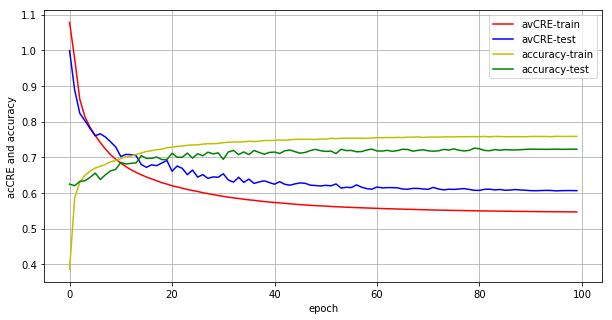

In [17]:
loss_tr = Monitor.history['loss']
acc_tr = Monitor.history['accuracy']
loss_te = Monitor.history['val_loss']
acc_te = Monitor.history['val_accuracy']

nEpoch=100

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
ax.grid()
ax.plot(range(nEpoch),loss_tr,c='r')
ax.plot(range(nEpoch),loss_te,c='b')
ax.plot(range(nEpoch),acc_tr,c='y')
ax.plot(range(nEpoch),acc_te,c='g')
ax.set_xlabel('epoch')
ax.set_ylabel('acCRE and accuracy')
plt.legend(['avCRE-train','avCRE-test','accuracy-train','accuracy-test'],loc='best')
plt.show


In [18]:
# plot accuracy of training set and test set vs epoch steps
nEpoch=30
loss_tr = GradsReal_loss.real_loss_tr
loss_te = GradsReal_loss.real_loss_te
acc_tr = GradsReal_loss.accuracy_tr
acc_te = GradsReal_loss.accuracy_te

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,1,1)
ax1.grid()
ax1.plot(range(nEpoch),acc_tr,c='r')
ax1.plot(range(nEpoch),acc_te,c='b')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
plt.legend(['train','test'],loc='best')
plt.show



AttributeError: 'MyHistory' object has no attribute 'real_loss_tr'

ValueError: x and y must have same first dimension, but have shapes (30,) and (100,)

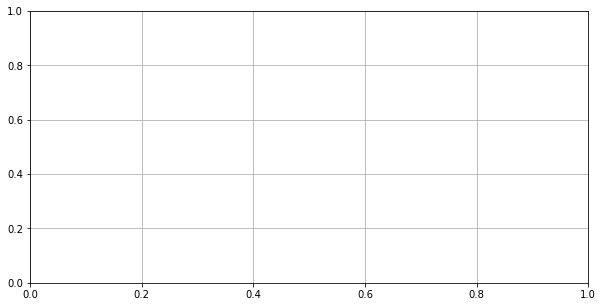

In [19]:
# plot loss value of training set and test set vs epoch steps
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,1,1)
ax1.grid()
ax1.plot(range(nEpoch),loss_tr,c='r')
ax1.plot(range(nEpoch),loss_te,c='b')
ax1.set_xlabel('epoch')
ax1.set_ylabel('aveCRE')
plt.legend(['train','test'],loc='best')
plt.show

In [20]:
# hidden layer activity analysis by PCA 
Hidd_state = model.layers[0](trainX).numpy()

corrMatrix = np.corrcoef(Hidd_state,rowvar=False)
eigen=la.eig(corrMatrix)
eigenValues=eigen[0]
eigenValues=np.sort(eigenValues)[::-1]
RAT=[]
eigen_sum=0
for i in range(len(eigenValues)):
    eigen_sum=eigen_sum+eigenValues[i]
    ratio=eigen_sum/sum(eigenValues)
    RAT.append(ratio)

j=0
for i in range(10):
    if RAT[i]>=0.95:
        j=i
        break
j



NameError: name 'la' is not defined

In [21]:
# plot batch CRE vs n = epoch * batch per epoch ( 1 epoch * batches per epoch) 


loss_batch=np.array(GradsReal_loss.batch_loss)[:,0]
acc_batch=np.array(GradsReal_loss.batch_loss)[:,1]

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,5))
axb=fig.add_subplot(1,1,1)
axb.grid()
axb.plot(range(len(loss_batch)),loss_batch,c='b')
axb.plot(range(len(loss_batch)),acc_batch,c='y')
axb.set_xlabel('batches')
axb.set_ylabel('aveCRE_batch and accuracy')
plt.legend(['aveCRE','accuracy'],loc='best')
#ax2.set_xticks(range(0,721,72))
plt.show


AttributeError: 'MyHistory' object has no attribute 'batch_loss'

In [22]:
# plot ||W(n+1)- W(n)|| / ||Wn|| vs n batch 
from numpy import linalg as la
weight_batch=GradsReal_loss.batch_weight

dim_input = 10
dim_hidd = 21
dim_output = 3

W_change=[]
W = []
w_nplus1=np.empty((297,))
for i in range(len(loss_batch)):
  w_n = w_nplus1
  w1 = weight_batch[i][0].reshape((1,dim_input*dim_hidd))[0]
  b1 = weight_batch[i][1]
  w2 = weight_batch[i][2].reshape((1,dim_hidd*dim_output))[0]
  b2 = weight_batch[i][3]
  w_nplus1 = np.concatenate((w1,b1,w2,b2),axis=0)
  w_change = la.norm(w_nplus1-w_n)/la.norm(w_n)
  W_change.append(w_change)
  W.append(w_nplus1)

len(W_change)

fig=plt.figure(figsize=(10,5))
axw=fig.add_subplot(1,1,1)
axw.grid()
axw.plot(range(len(loss_batch)),W_change ,c='b')

axw.set_xlabel('batches')
axw.set_ylabel('||W(n+1)- W(n)|| / ||Wn||')
plt.show

AttributeError: 'MyHistory' object has no attribute 'batch_weight'

In [23]:
# plot grad vs batches
# compute the learning rate(epsilon)
# you can change the initial value of decay steps
#import numpy as np
#ini_lr = 0.01
#lr = []
#decay_steps = 144
#epoch =300
#decay_rate=0.96
#batchs = 144
#for epoch in range(epoch):
#  eps=ini_lr * decay_rate ** (epoch/decay_steps)
#  for step in range(batchs):
#    lr.append(eps)

In [24]:
# plot learning rate (epsilon)
lr=GradsReal_loss.lr

fig=plt.figure(figsize=(10,5))
axE=fig.add_subplot(1,1,1)
axE.grid()
axE.plot(range(len(lr)),lr ,c='b')
axE.set_xlabel('batchs')
axE.set_ylabel('learning rate')
#ax4.set_xticks(range(0,21600,72))
plt.show

AttributeError: 'MyHistory' object has no attribute 'lr'

In [25]:
# compute ||Gn|| = ( 1/ ε(n) ) || W(n+1)- W(n)|| and plot ||Gn||/d 

d = 297  # when h = 21
learning_rate = 0.01
Grad = []

for i in range (len(loss_batch)-1):
  grad = (la.norm(W[i+1]-W[i]))/(learning_rate*d)
  Grad.append(grad)

fig=plt.figure(figsize=(10,5))
ax5=fig.add_subplot(1,1,1)
ax5.grid()
ax5.plot(range(len(loss_batch)-1),Grad ,c='b')
ax5.set_xlabel('batches')
ax5.set_ylabel('||Gn||/d ')
#ax5.set_xticks(range(0,921,92))
plt.show
 



NameError: name 'loss_batch' is not defined

# Problem 6-2

In [18]:
Houtput = model.layers[0](trainX).numpy()

In [19]:
df = pd.DataFrame(Houtput)
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.683464,1.102971,0.665523,0.566712,0.104990,0.093170,1.693256,0.591195,0.000000,1.058354,...,0.000000,0.000000,0.688767,0.455346,0.000000,0.256731,0.501805,0.165687,0.000000,0.000000
1,0.317949,0.298892,0.000000,0.000000,0.000000,0.000000,0.000000,0.466375,0.000000,0.306816,...,0.401568,0.744068,0.000000,0.175648,0.000000,0.000000,0.000000,0.753929,0.294154,0.324412
2,0.000000,0.199920,0.303095,0.000000,0.000000,0.211142,0.671455,0.191207,0.000000,0.391191,...,1.072552,0.000000,0.000000,0.725556,0.000000,1.672746,0.000000,0.000000,0.940605,0.258374
3,0.000000,0.249117,0.590224,0.060363,0.000000,0.281145,0.863496,0.000000,0.000000,0.393611,...,0.311684,0.000000,0.000000,0.601318,0.000000,1.183053,0.000000,0.288369,0.411788,0.455523
4,0.000000,0.000000,0.000000,0.218729,0.000000,1.327064,0.550283,0.123101,0.000000,0.380374,...,0.000000,1.661167,0.165686,0.000000,1.898670,0.000000,0.000000,0.263340,0.000000,0.000000
5,0.647986,1.178639,0.000000,0.034829,0.188044,0.000000,0.613559,1.490280,0.000000,1.104934,...,0.000000,0.994477,0.370513,0.135237,0.000000,0.000000,0.917049,0.557797,0.000000,0.081860
6,0.000000,0.805842,0.143432,0.000000,0.188151,0.000000,0.000000,0.907810,0.000000,0.620810,...,0.000000,0.867488,0.000000,0.332062,0.000000,0.000000,0.004085,0.854156,0.278595,0.681590
7,0.000000,0.000000,0.913898,0.731482,0.000000,0.813549,1.077810,0.000000,0.000000,0.269405,...,0.000000,0.000000,0.000000,0.431714,0.307827,0.194847,0.000000,0.514698,0.229242,1.433333
8,0.000000,0.000000,0.592489,0.477186,0.144150,0.493728,0.263176,0.000000,0.000000,0.173433,...,0.000000,0.000000,0.000000,0.468575,0.337314,1.301441,0.000000,0.696009,0.000000,0.253083
9,0.630629,0.732108,0.297401,0.020830,0.000000,0.000000,0.786799,0.602974,0.000000,0.635591,...,0.195312,0.000000,0.438970,0.408779,0.000000,1.130270,0.464546,0.436292,0.000000,0.126735


In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf

,principal component 1,principal component 2,principal component 3
0,-0.423099,-0.229241,-1.341183
1,-0.962135,-0.370134,0.625938
2,-0.842767,-0.741336,0.494660
3,-0.690101,-0.410015,0.354746
4,1.290969,-0.527218,0.892991
5,-0.644451,0.129969,-0.467920
6,-0.830274,0.199354,0.504253
7,-0.014966,-0.246425,0.424761
8,-0.513848,0.015715,0.962299
9,-0.976507,-0.348612,-0.186842


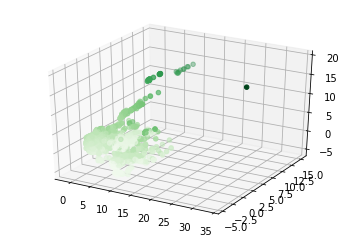

In [21]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(principalDf.iloc[:,0],principalDf.iloc[:,1],principalDf.iloc[:,2], c=principalDf.iloc[:,2], cmap='Greens')

In [22]:
df_trainx = pd.DataFrame(trainX.numpy())
df_trainy = pd.DataFrame(np.argmax(trainY, axis=1))
CL1 = pd.DataFrame()
CL2 = pd.DataFrame()
CL3 = pd.DataFrame()
for i in range(18388):
    if df_trainy.iloc[i,0] == 0:
        CL1 = CL1.append(pd.DataFrame(df_trainx.iloc[i,:]).T)
    elif df_trainy.iloc[i,0] == 1:
        CL2 = CL2.append(pd.DataFrame(df_trainx.iloc[i,:]).T)
    else:
        CL3 = CL3.append(pd.DataFrame(df_trainx.iloc[i,:]).T)

In [23]:
CL1=np.random.permutation(CL1)
CL2=np.random.permutation(CL2)
CL3=np.random.permutation(CL3)
CL1=tf.convert_to_tensor(CL1, dtype=tf.float32)
CL2=tf.convert_to_tensor(CL2, dtype=tf.float32)
CL3=tf.convert_to_tensor(CL3, dtype=tf.float32)
Houtput_1 = model.layers[0](CL1).numpy()
Houtput_2 = model.layers[0](CL2).numpy()
Houtput_3 = model.layers[0](CL3).numpy()

In [24]:
df_1 = pd.DataFrame(Houtput_1)
df_2 = pd.DataFrame(Houtput_2)
df_3 = pd.DataFrame(Houtput_3)

In [25]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=3)
pca_3 = PCA(n_components=3)
principalComponents_1 = pca_1.fit_transform(df_1)
principalDf_1 = pd.DataFrame(data = principalComponents_1,columns = ['1','2','3'])
principalComponents_2 = pca_2.fit_transform(df_2)
principalDf_2 = pd.DataFrame(data = principalComponents_2,columns = ['1','2','3'])
principalComponents_3 = pca_3.fit_transform(df_3)
principalDf_3 = pd.DataFrame(data = principalComponents_3,columns = ['1','2','3'])


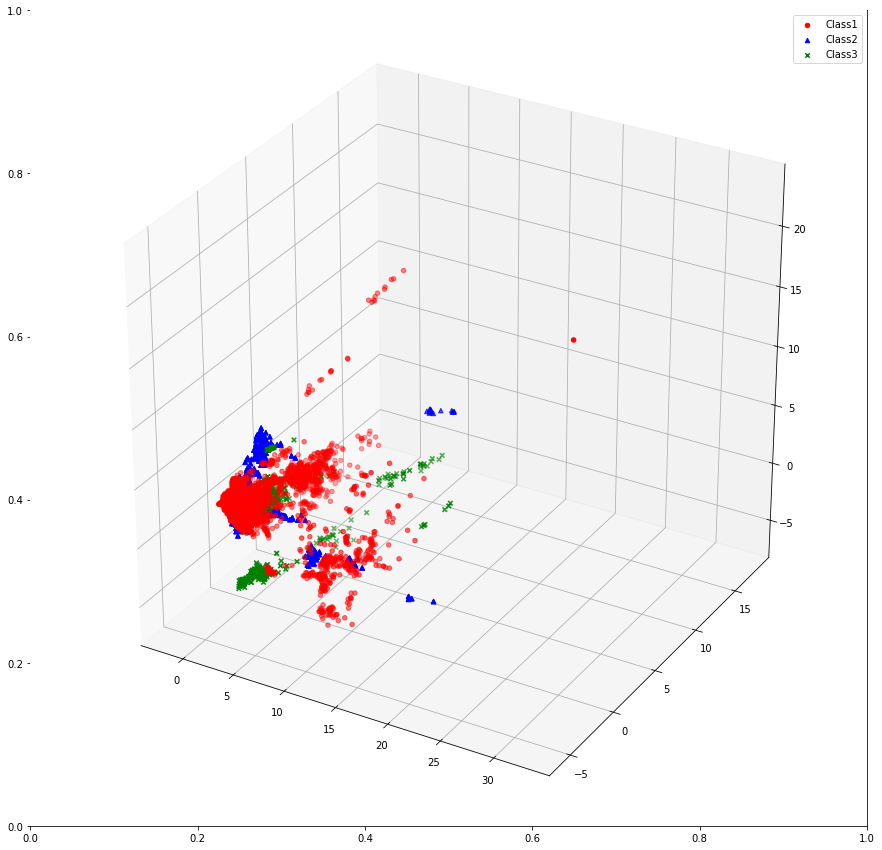

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
fig, ax = plt.subplots(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalDf_1.iloc[:,0],principalDf_1.iloc[:,1],principalDf_1.iloc[:,2],c='r',marker='o',label='Class1')
ax.scatter(principalDf_2.iloc[:,0],principalDf_2.iloc[:,1],principalDf_2.iloc[:,2],c='b',marker='^',label='Class2')
ax.scatter(principalDf_3.iloc[:,0],principalDf_3.iloc[:,1],principalDf_3.iloc[:,2],c='g',marker='x',label='Class3')
ax.legend()

# Problem 6-3

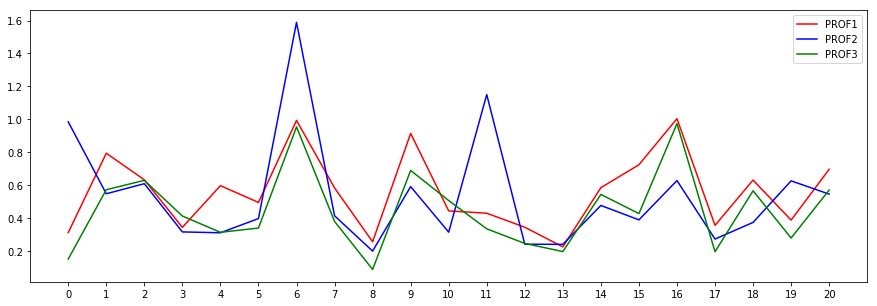

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(pd.DataFrame(Houtput_1).mean(),color="red",label="PROF1")
plt.plot(pd.DataFrame(Houtput_2).mean(),color="blue",label="PROF2")
plt.plot(pd.DataFrame(Houtput_3).mean(),color="green",label="PROF3")
plt.xticks(range(0, 21))
plt.legend()

# Problem 6-4

In [33]:
for i in range(20):
    if abs(pd.DataFrame(Houtput_1).mean()[i] - pd.DataFrame(Houtput_2).mean()[i])> 0.7:
        print(i)

11


In [37]:
for i in range(20):
    if abs(pd.DataFrame(Houtput_1).mean()[i] - pd.DataFrame(Houtput_3).mean()[i])> 0.29:
        print(i)

15


In [40]:
for i in range(20):
    if abs(pd.DataFrame(Houtput_2).mean()[i] - pd.DataFrame(Houtput_3).mean()[i])> 0.83:
        print(i)

0


the 11th hidden neuron achieve best DIFFERENTIATION between class C1 versus C2

the 15th hidden neuron achieve best DIFFERENTIATION between class C1 versus C3

the 1st hidden neuron achieve best DIFFERENTIATION between class C2 versus C3